 # DL기반 시계열 모델링

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten, GlobalMaxPool1D
from keras.optimizers import Adam

import joblib

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

### 1) 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### 2) 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### 3) 시계열분해 plot

In [4]:
def decomp_plot(decomp) :
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')
    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')
    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')
    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

### 4) 2차원 --> 3차원 변환(for LSTM, CNN)

In [5]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        output_X.append(x.iloc[i:i+timestep])
        output_y.append(y.iloc[i+timestep-1])
    return np.array(output_X), np.array(output_y)

### 5) 스케일링을 위한 함수
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

In [6]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

## (3) 데이터 불러오기

* 31번 파일에서 저장한 데이터를 로딩합니다.

In [7]:
data2 = joblib.load('data2.pkl')
data2.head()

Datetime  Temperature  Humidity  Count      y  weekend  lag24  \
0 2018-06-12 00:00:00         18.0      94.0    470  385.0        0  353.0   
1 2018-06-12 01:00:00         17.7      92.0    454  206.0        0  232.0   
2 2018-06-12 02:00:00         17.7      87.0    385  144.0        0  194.0   
3 2018-06-12 03:00:00         17.5      87.0    206  296.0        0  324.0   
4 2018-06-12 04:00:00         17.5      84.0    144  740.0        0  807.0   

      MA4  Diff1  Diff24  Seasonal24  Seasonal168  Active_1  Active_2  
0  904.50   86.0  -448.0 -538.479131  -677.133287         0         0  
1  606.25  -16.0  -101.0 -718.890590  -789.535569         0         0  
2  423.25  -69.0    32.0 -849.274704  -899.121879         0         0  
3  378.75 -179.0   -26.0 -822.281649  -847.300450         0         0  
4  297.25  -62.0   -50.0 -587.253003  -535.535073         0         0

# 2.전처리1

## (1) 데이터 분할

### 1) x, y 나누기

* .values(넘파이 어레이)로 변환해서 저장하는 이유 ➡ 데이터 스플릿 index를 적용해서 데이터를 가져오기 위해서

In [8]:
target = 'y'

x = data2.drop([target, 'Datetime'], axis = 1)
y = data2.loc[:, target]

### 2) 시계열 데이터 분할

In [9]:
val_size = 24 * 14
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

## (2) 스케일링

In [10]:
# x
scaler_x = MinMaxScaler()
x_train_s2 = scaler_x.fit_transform(x_train)
x_val_s2 = scaler_x.transform(x_val)

In [11]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

# 3.모델링1 : DNN

## (1) 학습 및 예측

* 설계

In [12]:
x_train_s2.shape

(1150, 12)

In [13]:
nfeatures = x_train_s2.shape[1]

clear_session()

model1 = Sequential([Dense(16, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

* 학습

In [14]:
hist = model1.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

Epoch 1/50
29/29 [==============================] - 2s 18ms/step - loss: 0.0421 - val_loss: 0.0177
Epoch 2/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0126
Epoch 3/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.0145
Epoch 4/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0129
Epoch 5/50
29/29 [==============================] - 0s 9ms/step - loss: 0.0113 - val_loss: 0.0124
Epoch 6/50
29/29 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 7/50
29/29 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 8/50
29/29 [==============================] - 0s 9ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 9/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 10/50
29/29 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 11/50
29/29 

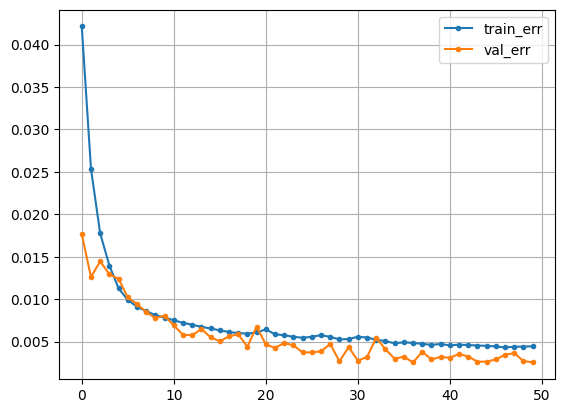

In [15]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [16]:
pred = model1.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

11/11 [==============================] - 0s 12ms/step


## (2) 평가

### 1) 검증성능

In [17]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 181.9051370166597
MAPE: 0.22286609440408145
R2  : 0.7427492173449095


### 2) 결과 시각화

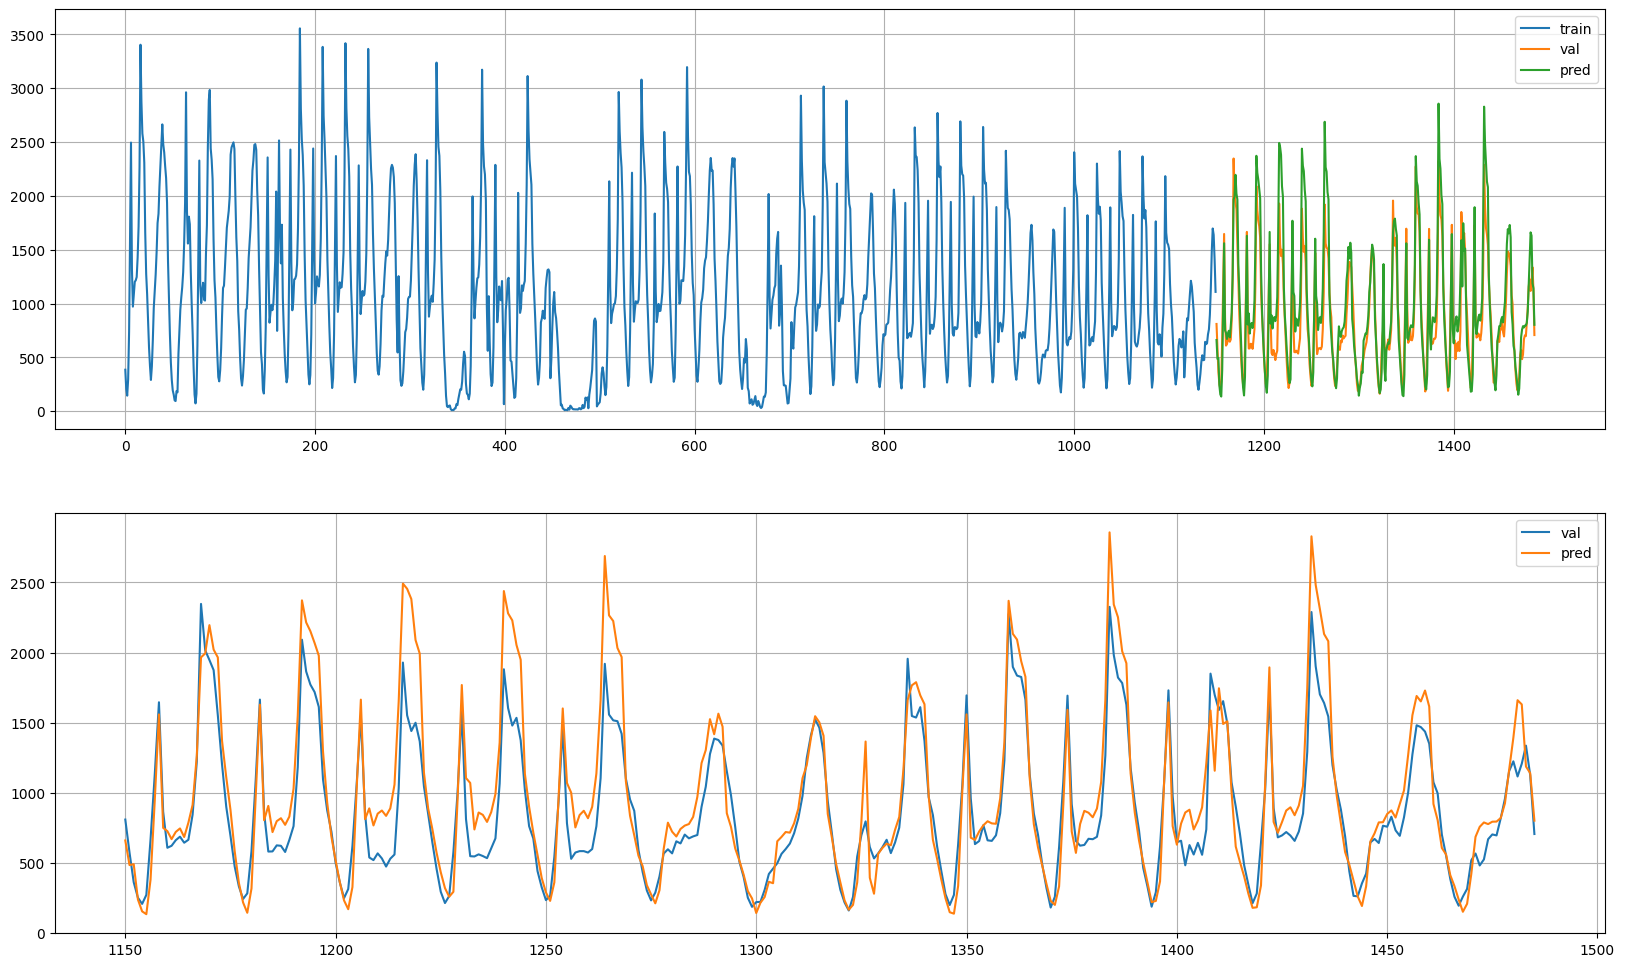

In [18]:
plot_model_result(y_train, y_val, pred)

# 4.전처리2

## (1) 3차원 구조로 만들기

In [19]:
x.shape, y.shape

((1486, 12), (1486,))

In [20]:
timesteps = 24
x2, y2 = temporalize(x, y, timesteps)

In [21]:
x2.shape, y2.shape

((1463, 24, 12), (1463,))

## (2) 시계열 데이터 분할

In [22]:
val_size = 24 * 14
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

# 5.모델링2 : LSTM

## (1) 3차원 데이터셋 전처리 : 스케일링

In [23]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

In [24]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

## (2) 학습 및 예측

* 설계

In [25]:
n_features = x_train_s3.shape[2]

clear_session()

model2 = Sequential([
            LSTM(32, input_shape = (timesteps, n_features), return_sequences = True),
            LSTM(16, return_sequences = True),
            LSTM(8),
            Dense(8, activation = 'relu'),
            Dense(1)
            ])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

* 학습

In [26]:
x_train_s3.shape, y_train_s3.shape

((1127, 24, 12), (1127, 1))

In [27]:
hist = model2.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
29/29 [==============================] - 10s 82ms/step - loss: 0.0495 - val_loss: 0.0225
Epoch 2/30
29/29 [==============================] - 1s 36ms/step - loss: 0.0289 - val_loss: 0.0112
Epoch 3/30
29/29 [==============================] - 1s 37ms/step - loss: 0.0190 - val_loss: 0.0143
Epoch 4/30
29/29 [==============================] - 1s 39ms/step - loss: 0.0152 - val_loss: 0.0137
Epoch 5/30
29/29 [==============================] - 1s 37ms/step - loss: 0.0127 - val_loss: 0.0199
Epoch 6/30
29/29 [==============================] - 1s 46ms/step - loss: 0.0120 - val_loss: 0.0112
Epoch 7/30
29/29 [==============================] - 2s 55ms/step - loss: 0.0103 - val_loss: 0.0158
Epoch 8/30
29/29 [==============================] - 2s 66ms/step - loss: 0.0104 - val_loss: 0.0138
Epoch 9/30
29/29 [==============================] - 2s 68ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 10/30
29/29 [==============================] - 2s 57ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 11

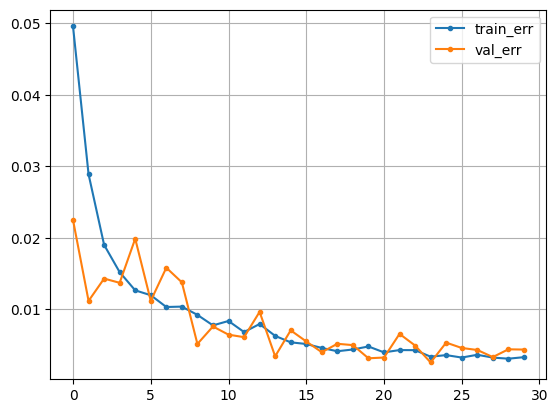

In [28]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [29]:
pred = model2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

11/11 [==============================] - 2s 13ms/step


## (3) 평가

### 1) 검증성능

In [30]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 172.6686157499041
MAPE: 0.1803587114144976
R2  : 0.7229004693117793


### 2) 결과 시각화

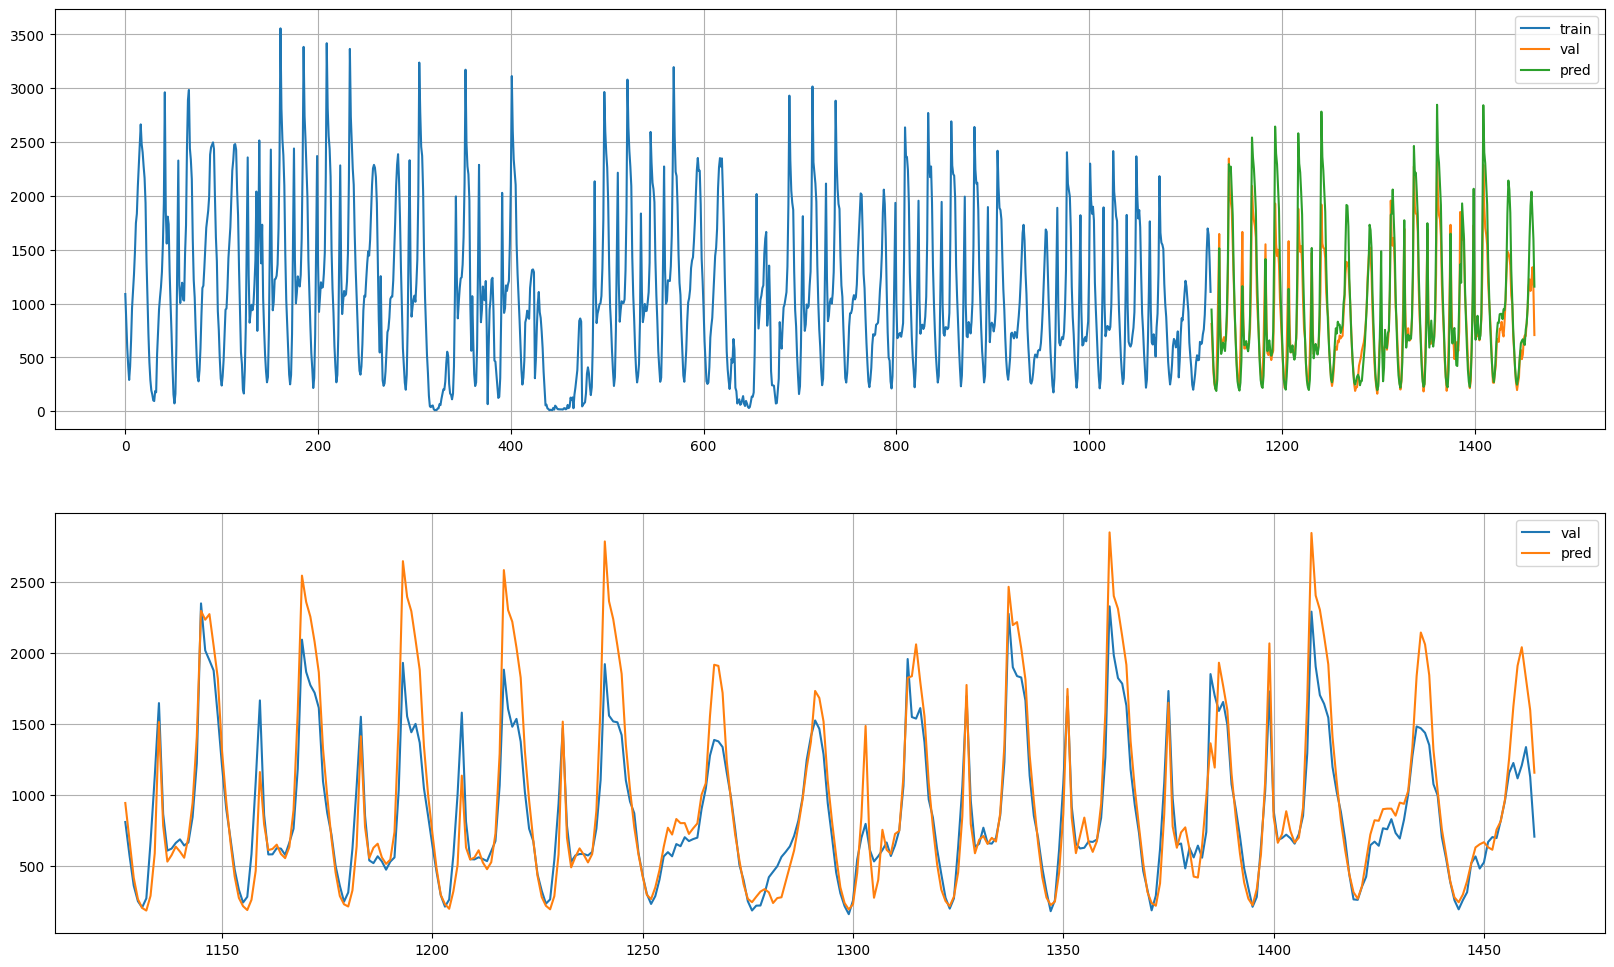

In [31]:
plot_model_result(y_train, y_val, pred)

# 6.모델링3 : CNN

## (1) 학습 및 예측

* 설계

In [32]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([
            Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
            Conv1D(16, 5, activation='relu', padding = 'same'),
            Flatten(),
            Dense(8, activation = 'relu'),
            Dense(1)
            ])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

* 학습

In [33]:
x_train_s3.shape, y_train_s3.shape

((1127, 24, 12), (1127, 1))

In [34]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
29/29 [==============================] - 1s 17ms/step - loss: 0.0603 - val_loss: 0.0241
Epoch 2/30
29/29 [==============================] - 0s 10ms/step - loss: 0.0165 - val_loss: 0.0132
Epoch 3/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0124 - val_loss: 0.0048
Epoch 4/30
29/29 [==============================] - 0s 10ms/step - loss: 0.0112 - val_loss: 0.0059
Epoch 5/30
29/29 [==============================] - 0s 10ms/step - loss: 0.0111 - val_loss: 0.0084
Epoch 6/30
29/29 [==============================] - 0s 12ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 7/30
29/29 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 8/30
29/29 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 9/30
29/29 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 10/30
29/29 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 11/

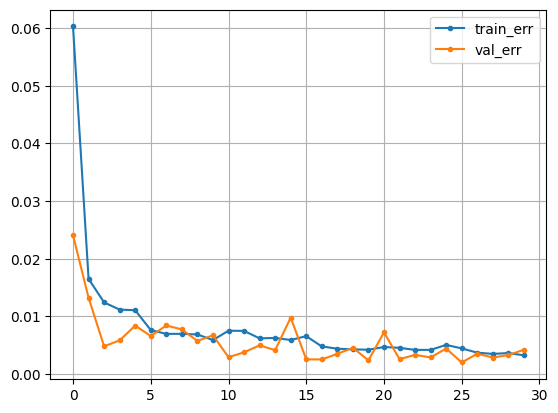

In [35]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [36]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

11/11 [==============================] - 0s 3ms/step


## (2) 평가

### 1) 검증성능

In [37]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 172.45183531443277
MAPE: 0.21490851595031546
R2  : 0.7879044955646618


### 2) 결과 시각화

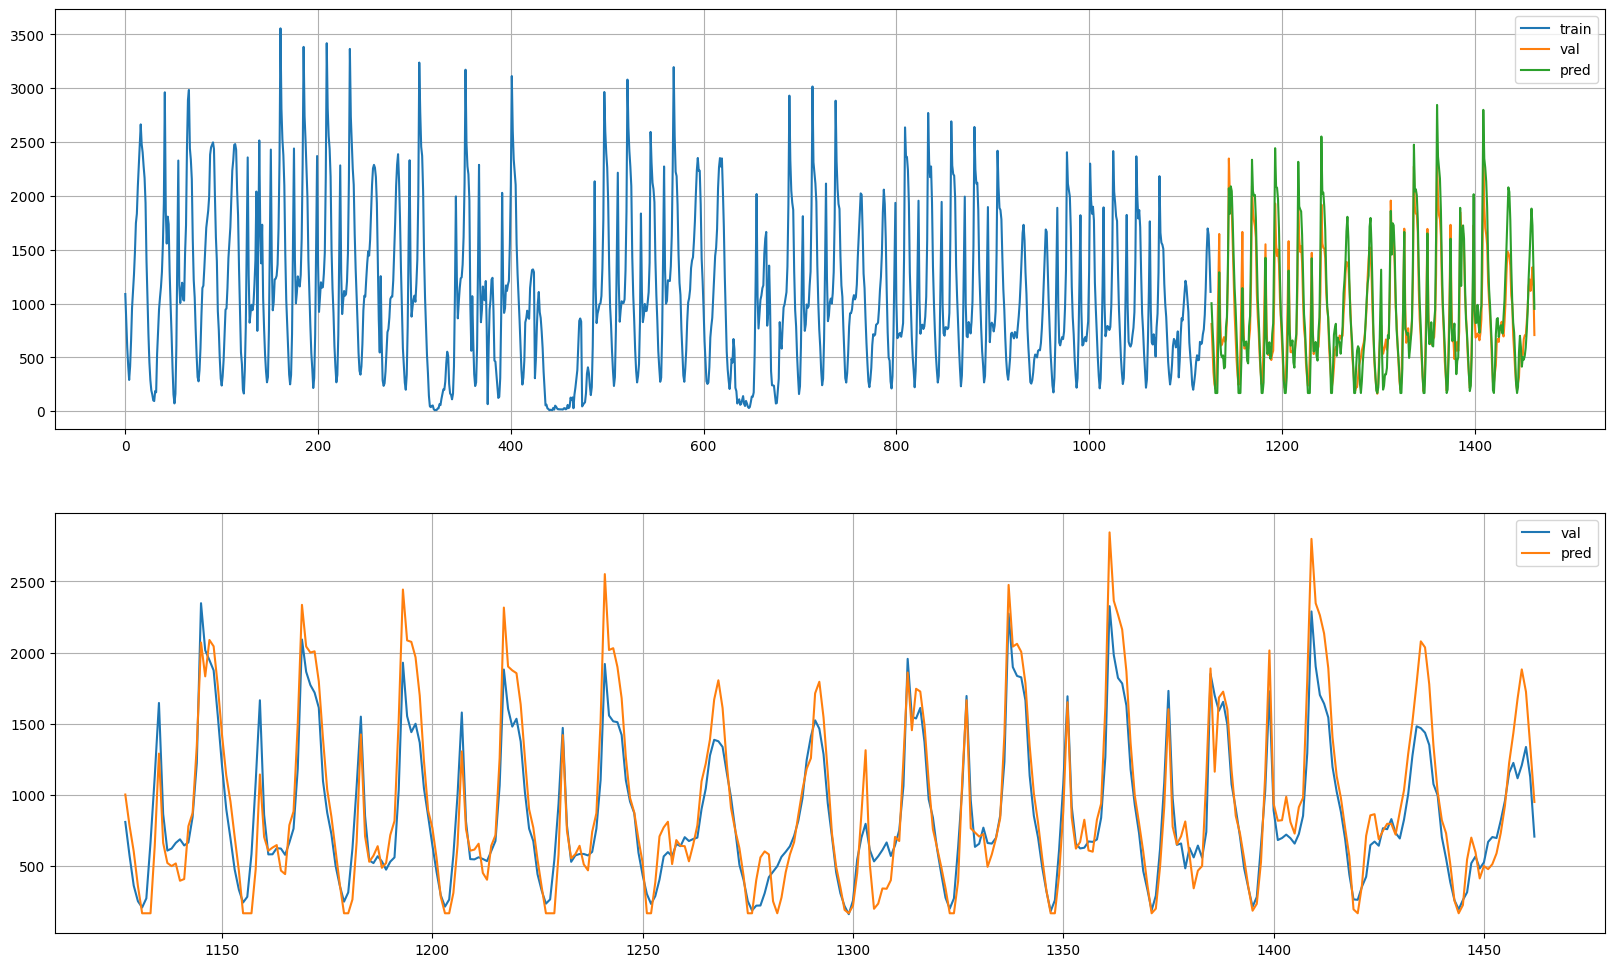

In [38]:
plot_model_result(y_train, y_val, pred)